# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
import urllib.request
import zipfile
import os

try:
    os.remove('./traffic-signs-data.zip')
except OSError:
    pass
print('Beginning data download...')

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip'  
urllib.request.urlretrieve(url, './traffic-signs-data.zip')
print('Data downloaded')
print('Unzipping')

z = zipfile.ZipFile('./traffic-signs-data.zip', 'r')
z.extractall('./data')
z.close()

try:
    os.remove('./traffic-signs-data.zip')
except OSError:
    pass

print('Done')

Beginning data download...
Data downloaded
Unzipping
Done


In [30]:
import pickle
import numpy as np
import cv2
import tensorflow as tf

In [3]:
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration


In [ ]:
import pandas as pd

In [4]:
pd.DataFrame({
    "# Examples": [len(X_train), len(X_valid), len(X_test)],
    "Shape": [X_train[0].shape, X_valid[0].shape, X_test[0].shape],
    "# Classes": [max(y_train) + 1, max(y_valid) + 1, max(y_test) + 1]
},index=["TRAIN", "VALIDATION", "TEST"], columns=["# Examples", "Shape", "# Classes"])

,# Examples,Shape,# Classes
TRAIN,34799,"(32, 32, 3)",43
VALIDATION,4410,"(32, 32, 3)",43
TEST,12630,"(32, 32, 3)",43


In [7]:
import matplotlib.pyplot as plt
from plot import plot_images, pie, hist
%matplotlib inline

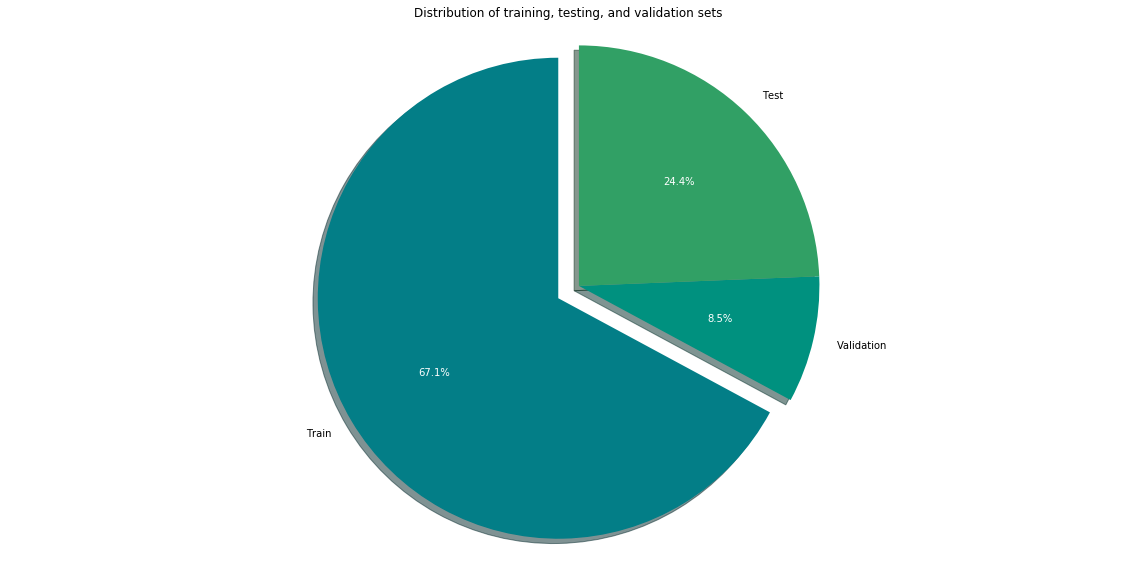

In [8]:
pie([len(X_train), len(X_valid), len(X_test)], labels=['Train', 'Validation', 'Test'], title='Distribution of training, testing, and validation sets')

Usually the training and test set have a 70/30 ratio as a rule of thumb. The data comes broken up already and I don't think altering the current ratios would affect the results in a meaningful way.

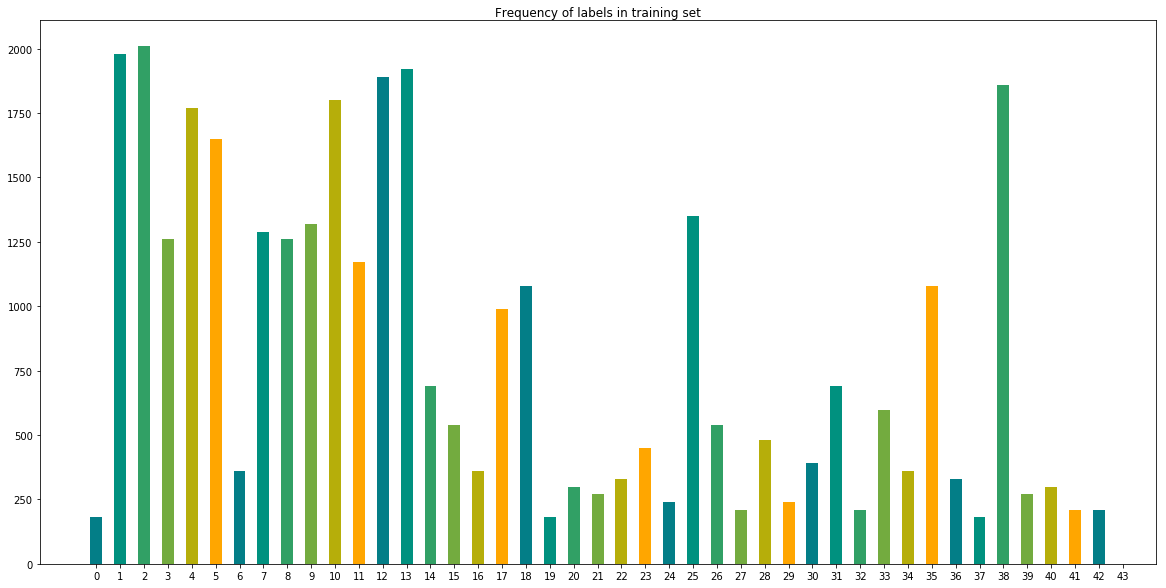

In [15]:
hist(y_train, 43, 'Frequency of labels in training set')

Labels with high frequency in the training set might cause the network to generalize towards those features. This can be addressed with image augmentation which we will return to after the first test.

### Pre-process the Data Set (normalization, grayscale, etc.)

In [10]:
from image import pre_process

In [11]:
X_train = pre_process(X_train)
X_valid = pre_process(X_valid)
X_test = pre_process(X_test)

### Model Architecture  


In [12]:
from nn import NN

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
network = NN()
network.add_train_data(X_train, y_train)
network.add_test_data(X_test, y_test)
network.add_validation_data(X_valid, y_valid)

network.add_layers([
    network.conv_layer(1, 32),
    network.max_pool(),
    network.conv_layer(32, 64),
    network.max_pool(),
    network.flatten(),
    network.fc_layer(4096, 1024),
    network.dropout(),
    network.fc_layer(1024, 400),
    network.dropout(),
    network.fc_layer(400, 43)
])

network.build(num_labels=max(y_train) + 1)

network.train()

Training...
EPOCH 1
Validation Accuracy = 0.652

EPOCH 2
Validation Accuracy = 0.834

EPOCH 3
Validation Accuracy = 0.902

EPOCH 4
Validation Accuracy = 0.922

EPOCH 5
Validation Accuracy = 0.927

EPOCH 6
Validation Accuracy = 0.942

EPOCH 7
Validation Accuracy = 0.939

EPOCH 8
Validation Accuracy = 0.942

EPOCH 9
Validation Accuracy = 0.953

EPOCH 10
Validation Accuracy = 0.936



Now we'll try again with an augmented data set

In [28]:
label_freq = {}
categorized_images = {}
for idx, label in enumerate(y_train):
    if label in label_freq:
        label_freq[label] += 1
    else:
        label_freq[label] = 1
    if label in categorized_images:
        categorized_images[label].append(X_train[idx])
    else:
        categorized_images[label] = [X_train[idx]]

freq_list = list(label_freq.values())
max_freq = max(freq)
factors = [round(max_freq / freq) for freq in freq_list]


[11, 1, 1, 2, 1, 1, 6, 2, 2, 2, 1, 2, 1, 1, 3, 4, 6, 2, 2, 11, 7, 7, 6, 4, 8, 1, 4, 10, 4, 8, 5, 3, 10, 3, 6, 2, 6, 11, 1, 7, 7, 10, 10]
11


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.